## Modeling and Inferential Analysis

In this section, we're going to look at the predictive power of certain match statistics by fitting a logistic regression base model, as well as RandomForests, to examine which ones are the most important.

This is different from our statistical tests previously that are looking at a hypothesis to decide whetherthe result is likely to have happened by chance.  Rather, this analysis helps us decide whether or not it could be beneficial to increase model complexity by using a feature due to its predictive power. (See https://statisticalhorizons.com/wp-content/uploads/GOFForLogisticRegression-Paper.pdf.)

Adding features to a model, ergo, increasing model complexity, is always a trade-off as increasing model complexity could lead to better results, but makes a model prone to overfitting (a statistical model that contains more parameters than can be justified by the data).

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# Set standard figure size for plots
mlp.rcParams['figure.figsize'] = (10,6)

# Set Seaborn Styles
sns.set()

# Set Color Palette that can be used for plotting
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

In [2]:
# Read in Results data from csv file.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')



In [3]:
# Store Feature Columns and Target Variable Column
features = ['rank_dif','ace_percent','doublefault_percent','serve_points_percent','return_points_percent','break_points_percent','points_won_percent']
predictor = ['win']

In [4]:
# Store Features and Target Columns in Variable
features_with_target = ['win','rank_dif','aces','double_faults','first_serves_in','first_serves_total','first_serve_points_won','first_serve_points_total',
                       'second_serve_points_won','second_serve_points_total','break_points_saved','break_points_serve_total','service_points_won',
                       'service_points_total','first_serve_return_won','first_serve_return_total','second_serve_return_won','second_serve_return_total',
                       'break_points_converted','break_points_converted','service_games_played','return_games_played','return_points_won',
                       'return_points_total','total_points_won','total_points_total','ace_percent','doublefault_percent','serve_points_percent',
                       'return_points_percent','break_points_percent','points_won_percent']

In [5]:
from sklearn.model_selection import train_test_split

# Split Training Data in Holdout Set and Training and Test Data sets
Xy_train = train.loc[:,features + predictor].dropna()
X = Xy_train.drop('win',axis=1)
y = Xy_train['win']

X_tune, X_hold, y_tune, y_hold = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.33, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train,X_test):
    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

# Get Scaled Training and Test Features
X_train, X_test, scaler = scale_data(X_train, X_test)

LR Scores:  [0.98942438 0.99045805 0.98997063 0.9892287  0.98967974]
Mean ROC AUC Score: 0.989752301468684
LR Score Range: 0.0012


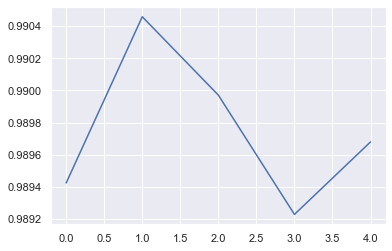

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def run_lr(X_train,y_train):
    """
    Run a Logistic Recression of Features and Target Variable. We're using ROC AUC Score with Cross Validation
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    lr = LogisticRegression(solver='lbfgs')
    
    lr_scores = cross_val_score(lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='roc_auc')
    
    print('LR Scores: ', lr_scores)
    print('Mean ROC AUC Score: {}'.format(lr_scores.mean()))
    print('LR Score Range: {}'.format(round(lr_scores.max() - lr_scores.min(),4)))
    _ = plt.plot(np.arange(len(lr_scores)),lr_scores)
    return lr

lr = run_lr(X_train,y_train)

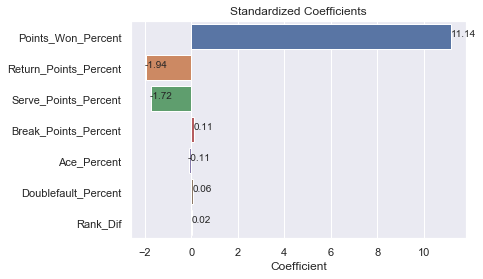

In [9]:
def plot_coef(X,y,features):
    """
    Plot the Beta values of a Logistic Regression based on the Features and Target Variable provided.
    """
    lr = LogisticRegression(solver='lbfgs')
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    lr.fit(X_train,y_train)
    std_coef = lr.coef_.reshape(-1,1).tolist()
    feature_names = [feature.title() for feature in features]
    coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
    coef_df['abs'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
    ax = sns.barplot(coef_df['coef'],coef_df.index)
    for i, row in enumerate(coef_df.iterrows()):
        row_values = row[1]
        if row_values.coef < 0:
            ax.text(row_values.coef - 0.05,i,round(row_values.coef,2))
        else:
            ax.text(row_values.coef + 0.01,i,round(row_values.coef,2))
    _ = plt.xlabel('Coefficient')
    _ = plt.title('Standardized Coefficients')

plot_coef(X_train,y_train,features)

In [11]:
# find correlations to target
corr_matrix = X_tune.corr().abs()

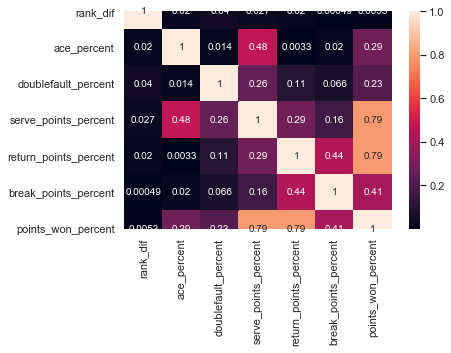

In [12]:
# Plot correlations for Tuning variables
sns.heatmap(corr_matrix,annot=True)
plt.show;

In [19]:
corr_matrix.points_won_percent[:-1]

rank_dif                 0.005335
ace_percent              0.289555
doublefault_percent      0.226045
serve_points_percent     0.792988
return_points_percent    0.794378
break_points_percent     0.413581
Name: points_won_percent, dtype: float64